# Why is 3x3 Filter Better than 7x7 Filter?
-> **weight(parameter 갯수) 차이 때문**
->(3x3 3개 =) 3*3*3 = 27,(7x7 1개=)7*7 = 49

27<49 이고, CNN에서 가중치는 모두 훈련이 필요한 것들이므로, 

**가중치 적다? = 훈련시킬 파라미터 적다 = 학습속도가 빨라진다 = 층의 갯수가 늘어나면서 feature의 비선형성을 증가시켜준다**

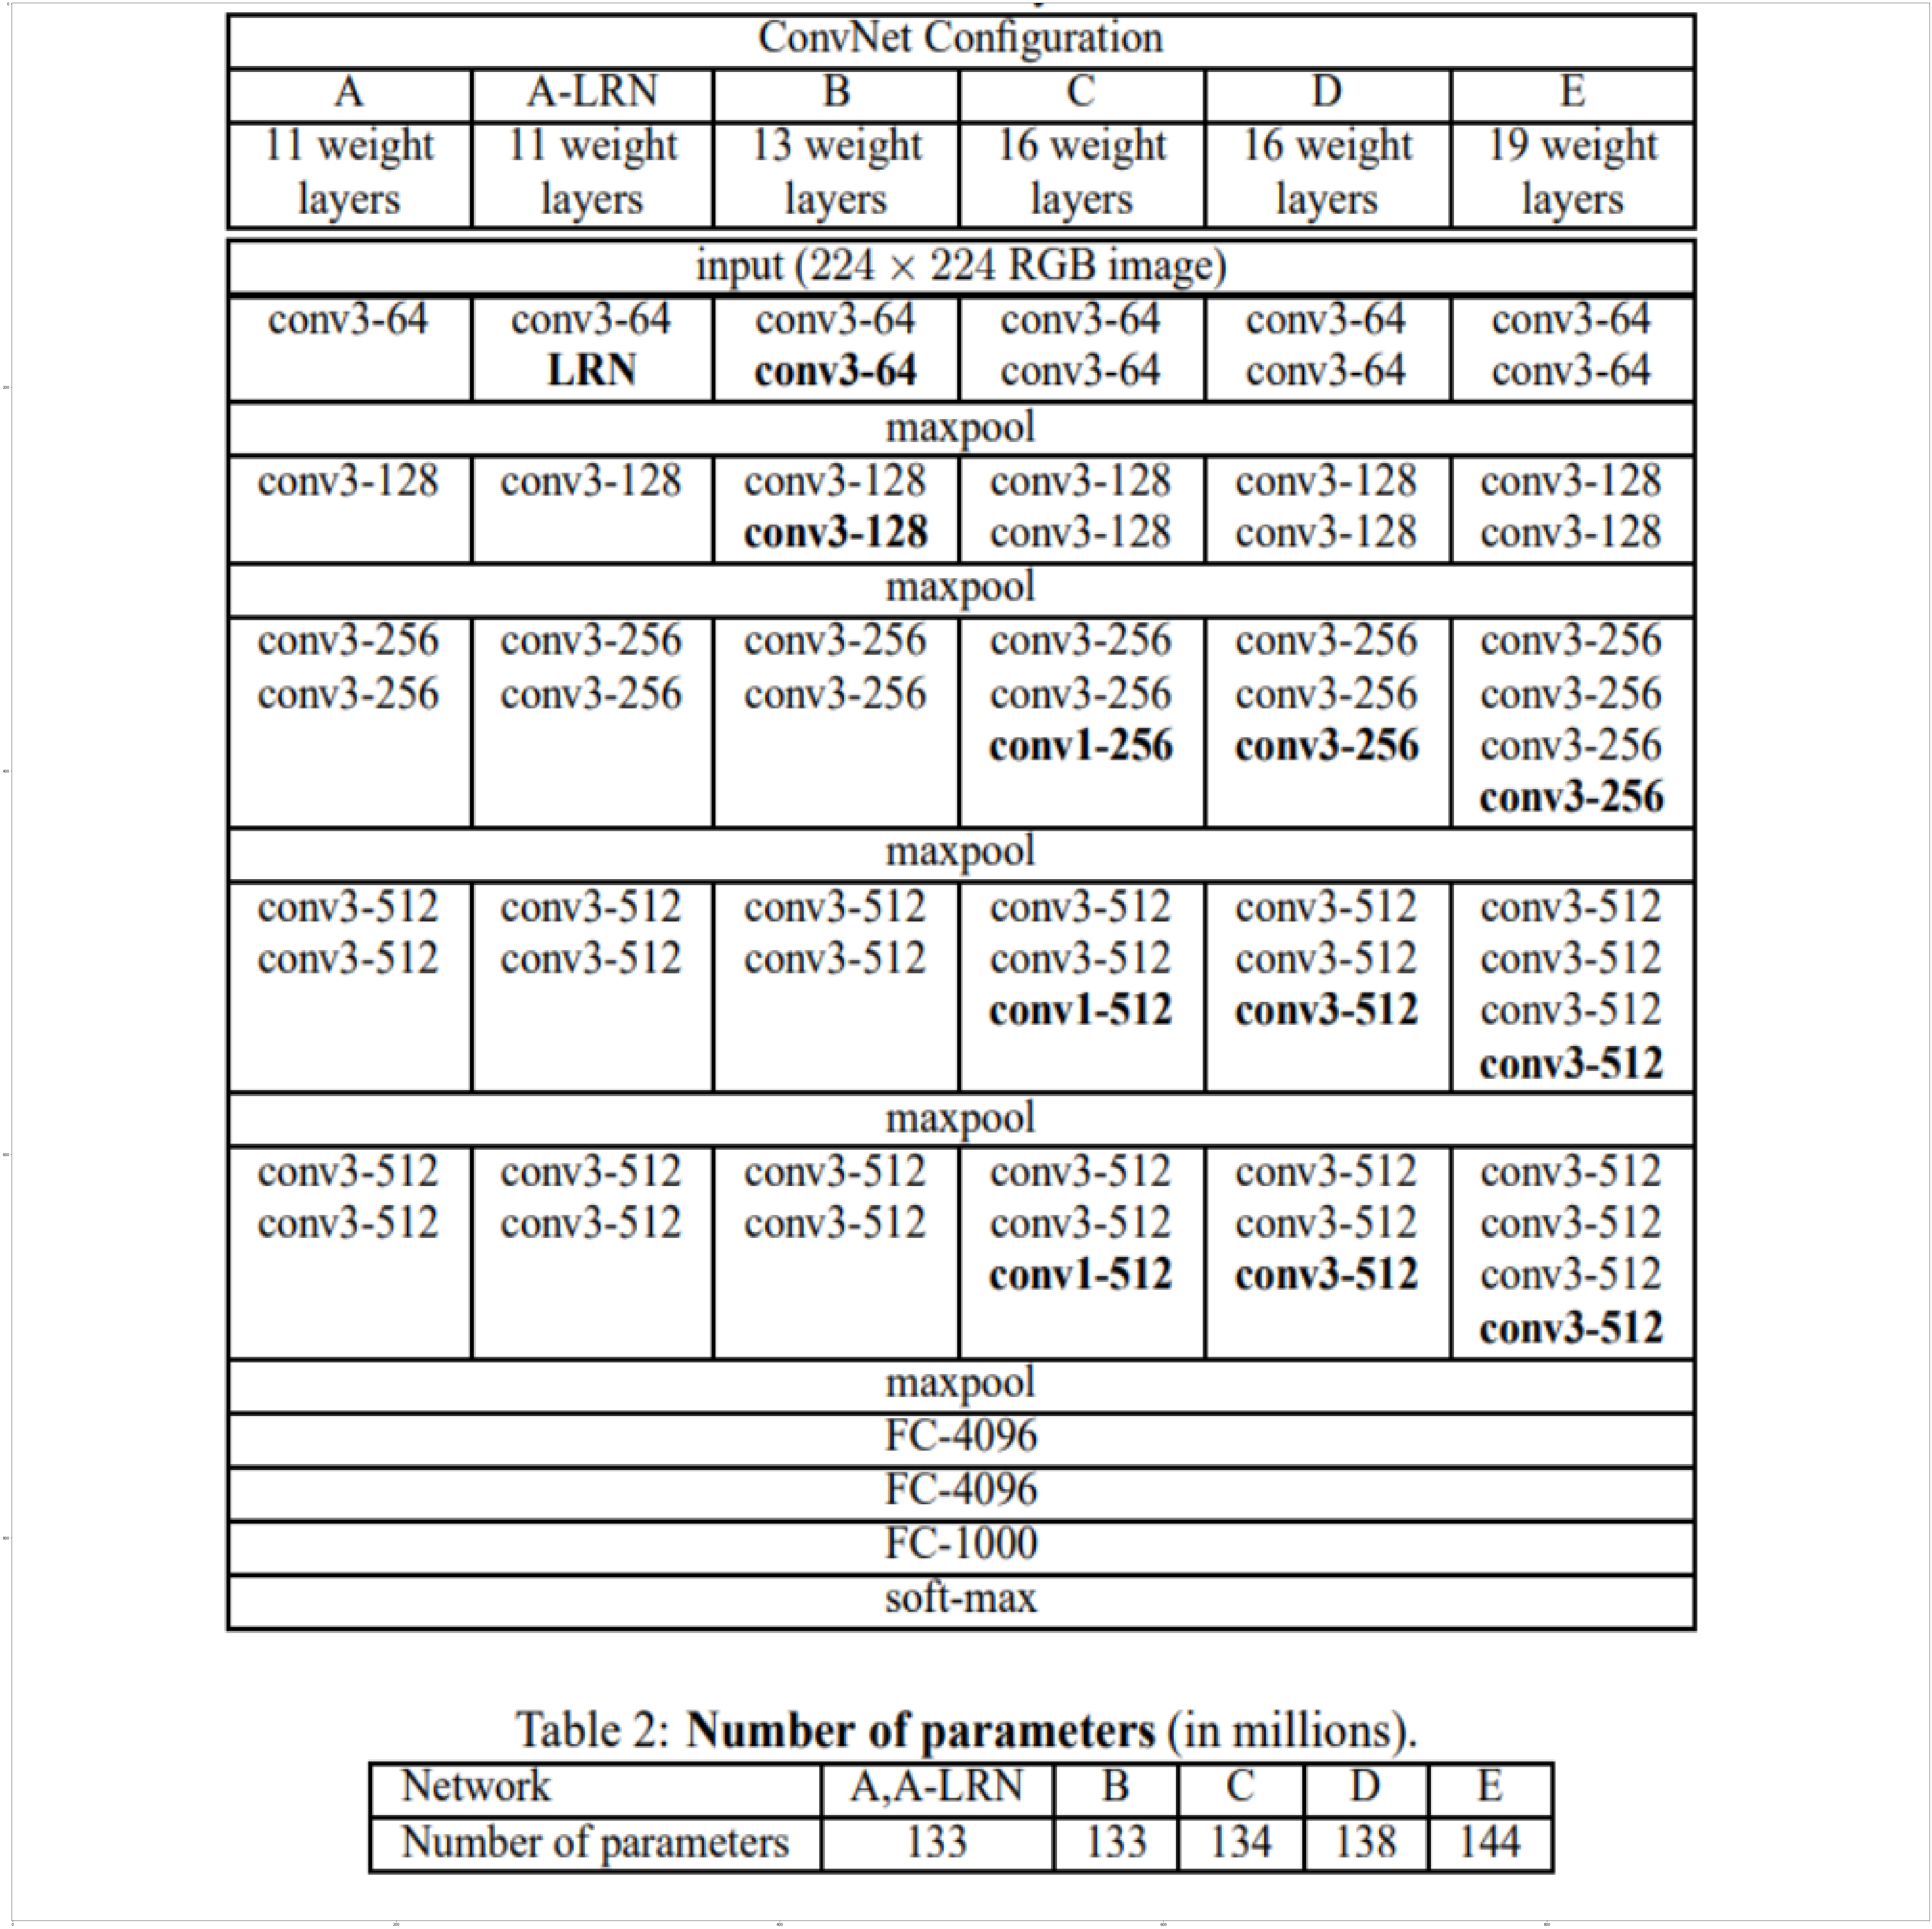

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
alpha = plt.imread('/content/vgvg.PNG')
delta = cv2.resize(alpha , (1000,1000))
plt.figure(figsize=(100,100))
plt.imshow(delta)
plt.show()

### VGG 13의 구조

In [5]:
from torchvision.models import vgg13,vgg13_bn,vgg16,vgg16_bn,vgg19,vgg19_bn
print(vgg13())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

In [6]:
print(vgg13_bn())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

위의 내용은 vgg13의 기본 version , batchnorm version 두녀석의 구조입니다.
vgg16, 19도 layer 쌓는거 빼곤 동일하기 때문에 일단 저기까지..

In [1]:
import torch.nn as nn
import torch.nn.init as init
import math

In [3]:
class VGG(nn.Module):
    def __init__(self, features):
        super(VGG , self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
                nn.Linear(512,512),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(512,512),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(512,10),
        )
        for i in self.modules(): # weight 초기화
            if isinstance(i , nn.Conv2d):
                n = i.kernel_size[0]*i.kernel_size[1]*i.out_channels
                i.weight.data.normal_(0,math.sqrt(2. /n))
                i.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def Make_Layer(alpha , batch_norm = False):
    layers = []
    in_channel = 3
    for i in alpha:
        if(i == 'Max'):
            layers+=[nn.MaxPool2d(kernel_size = 2 , stride = 2)]
        else:
            conv2d = nn.Conv2d(in_channel ,i, kernel_size = 3, padding =1)
            if batch_norm:
                layers+=[conv2d,nn.BatchNorm2d(i), nn.ReLU(inplace = True)]
            else: layers+=[conv2d,nn.ReLU(inplace = True)]
            in_channel = i
    return nn.Sequential(*layers)

def vgg13():
    return VGG(Make_Layer([64,64,'M',128,128,'M',256,256,'M',512,512,'M',512,512,'M']))

def vgg13_bn():
    return VGG(Make_Layer([64,64,'M',128,128,'M',256,256,'M',512,512,'M',512,512,'M'],batch_norm = True))

def vgg16():
    return VGG(Make_Layer([64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']))

def vgg16_bn():
    return VGG(Make_Layer([64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],batch_norm = True))